In [37]:
import os
from PIL import Image

# Define the directory containing the images
image_dir = "BPS-Microscopy/DAPI_MASK_images"

# # List to store image sizes
# image_sizes = []

# # Count the number of DAPI images and get their sizes
# dapi_image_count = 0
# total_images = 0
# for filename in os.listdir(image_dir):
#     if filename.endswith("_DAPI.tif"):
#         dapi_image_count += 1
#         image_path = os.path.join(image_dir, filename)
#         with Image.open(image_path) as img:
#             image_sizes.append(img.size)
#     total_images += 1

# # Get unique sizes and their counts
# unique_sizes = {size: image_sizes.count(size) for size in set(image_sizes)}

print(f"Total number of images: {total_images}")
print(f"Number of DAPI images: {dapi_image_count}")
print("Unique image sizes and their counts:")
# for size, count in unique_sizes.items():
#     print(f"Size: {size}, Count: {count}")


# Total number of images: 171505
# Number of DAPI images: 85752


Total number of images: 171505
Number of DAPI images: 85752
Unique image sizes and their counts:


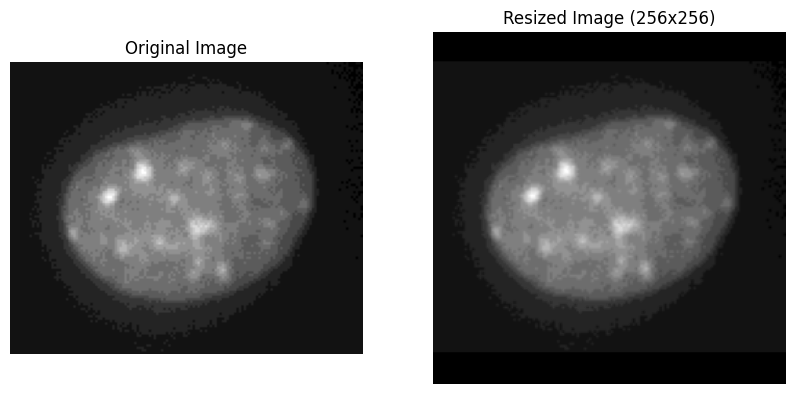

In [38]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import os

# Function to load and preprocess image
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tfio.experimental.image.decode_tiff(image)
    
    # Take only the first channel
    image = image[..., 0]
    
    # Expand dimensions to include a channel axis
    image = tf.expand_dims(image, axis=-1)
    
    resized_image = tf.image.resize_with_pad(image, 256, 256)
    return image, resized_image

# Function to normalize 16-bit image to 8-bit
def normalize_image(image):
    image = tf.cast(image, tf.float32)
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))  # Normalize to [0, 1]
    image = tf.cast(image * 255.0, tf.uint8)  # Scale to [0, 255] and convert to uint8
    return image

# Define the directory containing the images
image_dir = 'BPS-Microscopy/DAPI_MASK_images'

# Get an example image path
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('_DAPI.tif')]
example_image_path = image_files[109]

# Load and preprocess the example image
original_image, resized_image = load_and_preprocess_image(example_image_path)

# Normalize the images for display
original_image_normalized = normalize_image(original_image).numpy()
resized_image_normalized = normalize_image(resized_image).numpy()

# Plot the original and resized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_normalized[..., 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Resized Image (256x256)")
plt.imshow(resized_image_normalized[..., 0], cmap='gray')
plt.axis('off')

plt.show()


In [43]:
import pandas as pd

# Load the metadata from the Excel file
metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
print(metadata.head())


                               filename  dose_Gy particle_type  \
0  P244_73665165741-A6_014_018_DAPI.tif      0.0            Fe   
1  P244_73665165741-A6_019_006_MASK.tif      0.0            Fe   
2  P244_73665165741-A6_020_023_MASK.tif      0.0            Fe   
3  P244_73665165741-A6_001_042_DAPI.tif      0.0            Fe   
4  P244_73665165741-A6_002_051_MASK.tif      0.0            Fe   

   hr_post_exposure  
0                 4  
1                 4  
2                 4  
3                 4  
4                 4  


In [46]:
import os

# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only the valid DAPI images
metadata = metadata[metadata['filename'].str.endswith('_DAPI.tif')]

# Display the first few rows of the updated metadata
metadata.head()


,filename,dose_Gy,particle_type,hr_post_exposure,filepath
0,P244_73665165741-A6_014_018_DAPI.tif,0.0,Fe,4,BPS-Microscopy/DAPI_MASK_images/P244_736651657...
3,P244_73665165741-A6_001_042_DAPI.tif,0.0,Fe,4,BPS-Microscopy/DAPI_MASK_images/P244_736651657...
9,P244_73665165741-A6_004_011_DAPI.tif,0.0,Fe,4,BPS-Microscopy/DAPI_MASK_images/P244_736651657...
11,P244_73665165741-A6_015_008_DAPI.tif,0.0,Fe,4,BPS-Microscopy/DAPI_MASK_images/P244_736651657...
13,P244_73665165741-A6_010_001_DAPI.tif,0.0,Fe,4,BPS-Microscopy/DAPI_MASK_images/P244_736651657...


In [47]:
import tensorflow as tf

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image)
    image = image[..., 0]  # Take only the first channel
    image = tf.expand_dims(image, axis=-1)  # Expand dimensions to include a channel axis
    image = tf.image.resize_with_pad(image, 256, 256)
    image = tf.cast(image, tf.float32)
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))  # Normalize to [0, 1]
    return image

def process_metadata(row):
    # Extract relevant fields from the row
    dose = tf.cast(row['dose_Gy'], tf.float32)
    particle_type = 1.0 if row['particle_type'] == 'Fe' else 0.0  # Example binary encoding
    hr_post_exposure = tf.cast(row['hr_post_exposure'], tf.float32)
    return dose, particle_type, hr_post_exposure

def load_and_preprocess_from_path_label(row):
    image = load_image(row['filepath'])
    dose, particle_type, hr_post_exposure = process_metadata(row)
    return image, (dose, particle_type, hr_post_exposure)

# Create a TensorFlow Dataset from the DataFrame
dataset = tf.data.Dataset.from_tensor_slices(dict(metadata))
dataset = dataset.map(lambda row: load_and_preprocess_from_path_label(row))

# Batch and prefetch the dataset
batch_size = 32
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [52]:
from tensorflow.keras import layers, models

def create_model():
    inputs = layers.Input(shape=(256, 256, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    
    output_dose = layers.Dense(1, name='dose_output')(x)
    output_particle = layers.Dense(1, name='particle_output')(x)
    output_hr = layers.Dense(1, name='hr_output')(x)
    
    model = models.Model(inputs=inputs, outputs=[output_dose, output_particle, output_hr])
    model.compile(optimizer='adam', 
                  loss={'dose_output': 'mse', 'particle_output': 'mse', 'hr_output': 'mse'},
                  metrics={'dose_output': 'mae', 'particle_output': 'mae', 'hr_output': 'mae'})
    return model

model = create_model()
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 254, 254,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 127, 127,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 62, 62,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 60, 60,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 30, 30,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 115200)    │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │  7,372,864 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dose_output (Dense) │ (None, 1)         │         65 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ particle_output     │ (None, 1)         │         65 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hr_output (Dense)   │ (None, 1)         │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,465,731 (28.48 MB)

 Trainable params: 7,465,731 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(dataset, epochs=10)

# Plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='mae')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


Epoch 1/10
2680/2680 ━━━━━━━━━━━━━━━━━━━━ 899s 335ms/step - dose_output_mae: 0.2967 - hr_output_mae: 1.7021 - loss: 26.5024 - particle_output_mae: 0.3751
Epoch 2/10
2600/2680 ━━━━━━━━━━━━━━━━━━━━ 26s 333ms/step - dose_output_mae: 0.1984 - hr_output_mae: 2.8088 - loss: 60.6985 - particle_output_mae: 0.5704